In [1]:
import random

import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import numpy as np
from shapely.validation import make_valid
from shapely.geometry import MultiPolygon, box
from shapely import union_all

# Load Sentinel-2 tiles

In [2]:
# Step 1: Load the Sentinel-2 MGRS grid (replace with your downloaded file)
mgrs_grid_path = "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/grid.geojson"  # Downloaded MGRS grid file
mgrs_gdf = gpd.read_file(mgrs_grid_path)

# Ensure the grid is in a projected CRS (e.g., EPSG:27700 for your fields)
if mgrs_gdf.crs is None or mgrs_gdf.crs.to_epsg() != 27700:
    mgrs_gdf = mgrs_gdf.to_crs("EPSG:27700")

In [ ]:
# Step 2: Load your crop fields
fields_path = "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/ukfields.parquet"  # Replace with your Parquet file path
fields_gdf = gpd.read_parquet(fields_path)

# Ensure the fields are in EPSG:27700
if fields_gdf.crs is None:
    fields_gdf.set_crs("EPSG:27700", inplace=True)
elif fields_gdf.crs != "EPSG:27700":
    fields_gdf = fields_gdf.to_crs("EPSG:27700")

In [5]:
mgrs_gdf.shape[0]

56686

In [6]:
mgrs_gdf.head()

,name,id,epsg,mgrsRef,utmWkt,llWkt,geometry
0,01CCV,01CCV,32701,-72.01265627 177.18928449 -72.077536527 -179.9...,"MULTIPOLYGON(((300000 2000020,300000 1890220,4...",MULTIPOLYGON(((177.189340361676 -72.0124778858...,GEOMETRYCOLLECTION Z (POLYGON Z ((334972.535 -...
1,01CDH,01CDH,32701,-82.796942202 175.83834491 -82.852560274 -177 ...,"MULTIPOLYGON(((399960 800020,399960 690220,509...",MULTIPOLYGON(((175.835686552199 -82.7967201119...,GEOMETRYCOLLECTION Z (POLYGON Z ((375925.146 -...
2,01CDJ,01CDJ,32701,-81.907342379 176.62455327 -81.956740238 -177 ...,"MULTIPOLYGON(((399960 900040,399960 790240,509...",MULTIPOLYGON(((176.62230379644 -81.90694685766...,GEOMETRYCOLLECTION Z (POLYGON Z ((372461.541 -...
3,01CDK,01CDK,32701,-81.01647427 177.25448324 -81.060880975 -177 -...,"MULTIPOLYGON(((399960 1000000,399960 890200,50...",MULTIPOLYGON(((177.252200236163 -81.0164388283...,GEOMETRYCOLLECTION Z (POLYGON Z ((369006.023 -...
4,01CDL,01CDL,32701,-80.124666236 177.77028412 -80.164978249 -177 ...,"MULTIPOLYGON(((399960 1100020,399960 990220,50...",MULTIPOLYGON(((177.768297510956 -80.1244556090...,GEOMETRYCOLLECTION Z (POLYGON Z ((365555.504 -...


In [2]:
def efficient_intersection_with_validation(gdf1, gdf2):
    """
    Finds all rows in gdf1 that intersect with at least one geometry in gdf2, with validation and a progress bar.

    Parameters:
        gdf1 (GeoDataFrame): The first GeoDataFrame.
        gdf2 (GeoDataFrame): The second GeoDataFrame.

    Returns:
        GeoDataFrame: A subset of gdf1 with rows that intersect gdf2.
    """
    # Ensure CRS match
    if gdf1.crs != gdf2.crs:
        raise ValueError("CRS of gdf1 and gdf2 must match.")
    
    # Validate and fix invalid geometries
    gdf1 = gdf1[gdf1['geometry'].notnull()].copy()  # Remove NaN geometries
    gdf2 = gdf2[gdf2['geometry'].notnull()].copy()

    # gdf1['geometry'] = gdf1['geometry'].apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
    # gdf2['geometry'] = gdf2['geometry'].apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
    gdf1['geometry'] = gdf1['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)
    gdf2['geometry'] = gdf2['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

    # Build spatial index for gdf2
    sindex = gdf2.sindex

    # Initialize a list to store intersection results
    intersects = []

    # Iterate through gdf1 with a progress bar
    for _, row in tqdm(gdf1.iterrows(), total=len(gdf1), desc="Processing geometries"):
        if row.geometry.is_empty or row.geometry is None:
            intersects.append(False)
            continue

        possible_matches_index = list(sindex.intersection(row.geometry.bounds))
        possible_matches = gdf2.iloc[possible_matches_index]
        
        try:
            intersects.append(possible_matches.intersects(row.geometry).any())
        except Exception as e:
            print(f"Warning: Skipping an invalid geometry at index {_}. Error: {e}")
            intersects.append(False)

    # Add intersects column to gdf1
    gdf1['intersects'] = intersects

    # Filter rows where intersection is true
    result = gdf1[gdf1['intersects']].drop(columns=['intersects'])

    return result

In [8]:
intersecting_tiles_gdf = efficient_intersection_with_validation(mgrs_gdf, fields_gdf)

/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/shapely/constructive.py:180: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/shapely/constructive.py:180: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/.venv/lib/python3.9/site-packages/shapely/constructive.py:180: RuntimeWarning: divide by zero encou

In [9]:
intersecting_tiles_gdf.head()

,name,id,epsg,mgrsRef,utmWkt,llWkt,geometry
462,01MAV,01MAV,32701,0 179.4076728 0 -179.69502322 -0.90372312093 -...,"MULTIPOLYGON(((99960 10000000,99960 9890200,20...","MULTIPOLYGON(((179.407314038588 0,179.40677899...",GEOMETRYCOLLECTION Z (POLYGON Z ((177457.46 -2...
471,01MBV,01MBV,32701,0 -179.69502322 0 -178.79705281 -0.90428260986...,"MULTIPOLYGON(((199980 10000000,199980 9890200,...","MULTIPOLYGON(((-179.695202757055 0,-179.695604...",GEOMETRYCOLLECTION Z (POLYGON Z ((143486.857 1...
480,01MCV,01MCV,32701,0 -178.79705281 0 -177.89863766 -0.90461857889...,"MULTIPOLYGON(((300000 10000000,300000 9890200,...","MULTIPOLYGON(((-178.797052812354 0,-178.797320...",GEOMETRYCOLLECTION Z (POLYGON Z ((43436.761 14...
526,01NAA,01NAA,32601,0.90294079979 179.40722906 0.90372312093 -179....,"MULTIPOLYGON(((99960 100020,99960 -9780,209760...",MULTIPOLYGON(((179.406870077048 0.903121030127...,GEOMETRYCOLLECTION Z (POLYGON Z ((177424.56 -2...
535,01NBA,01NBA,32601,0.90372312093 -179.69535651 0.90428260986 -178...,"MULTIPOLYGON(((199980 100020,199980 -9780,3097...",MULTIPOLYGON(((-179.69553619554 0.903903730977...,GEOMETRYCOLLECTION Z (POLYGON Z ((143555.725 1...


In [10]:
intersecting_tiles_gdf.to_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/intersecting_tiles.geojson", driver="GeoJSON")

In [11]:
fields_gdf.to_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ukfields_validated.geojson", driver="GeoJSON")

In [6]:
def extract_polygons(geometry):
    """Extracts only the polygon parts from a GeometryCollection."""
    if geometry.geom_type == "Polygon":
        return geometry  # Return as-is
    elif geometry.geom_type == "MultiPolygon":
        return geometry  # Return as-is
    elif geometry.geom_type == "GeometryCollection":
        polygons = [geom for geom in geometry.geoms if geom.geom_type in ["Polygon", "MultiPolygon"]]
        return MultiPolygon(polygons) if polygons else None  # Convert list to MultiPolygon
    return None  # Ignore other geometry types

In [16]:
# Apply this function before exporting to GeoJSON
intersecting_tiles_gdf["geometry"] = intersecting_tiles_gdf["geometry"].apply(extract_polygons)
intersecting_tiles_gdf.to_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/intersecting_tiles_shapely.geojson", driver="GeoJSON")

In [19]:
fields_gdf[:3000].to_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ukfields_validated_3000.geojson", driver="GeoJSON")

# Postprocess results

In [5]:
first_date = fields_gdf["determination_datetime"].iloc[0]
print(f"1st date: {first_date}")
for i, date in enumerate(fields_gdf["determination_datetime"]):
    assert date == first_date, f"Date {i+1} does not match first date: {date}"

1st date: 2021-06-01 00:00:00+00:00


In [9]:
intersecting_tiles_gdf = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/intersections_gdf_correct_tiles.geojson")
intersecting_tiles_gdf.head(2)

,name,id,epsg,mgrsRef,utmWkt,llWkt,geometry
0,29UNA,29UNA,32629,55.046806305 -9 55.036748927 -7.4352342909 54....,"MULTIPOLYGON(((499980 6100020,499980 5990220,6...",MULTIPOLYGON(((-9.00031301962372 55.0469860315...,"MULTIPOLYGON Z (((-46849.084 594925.837 0, 626..."
1,29UNB,29UNB,32629,55.945375002 -9 55.934976119 -7.3992179406 55....,"MULTIPOLYGON(((499980 6200040,499980 6090240,6...",MULTIPOLYGON(((-9.00032022966423 55.9457344022...,"MULTIPOLYGON Z (((-36756.684 694667.322 0, 727..."


In [10]:
print(f"#Intersecting tiles: {intersecting_tiles_gdf.shape[0]}")

#Intersecting tiles: 72


In [21]:
def filter_sentinel_tiles(gdf: gpd.GeoDataFrame, tile_area: float = (109.8 * 1000) ** 2) -> gpd.GeoDataFrame:
    areas = []

    for row in gdf.itertuples():
        area = row.geometry.area
        areas.append(area)
    
    areas = np.array(areas)
    correct_inds = np.where((areas / tile_area >= 0.5) & (areas / tile_area <= 1.5))

    return gdf.iloc[correct_inds]

In [3]:
areas = []

for row in intersecting_tiles_gdf.itertuples():
    areas.append(row.geometry.area)

areas = np.array(areas)

In [4]:
tile_area = (109.8 * 1000) ** 2

In [10]:
correct_inds = np.where((areas / tile_area >= 0.5) & (areas / tile_area <= 1.5))
print(f"Correct tiles count: {len(correct_inds[0])}")
print(areas[correct_inds])

Correct tiles count: 72
[1.21065706e+10 1.21042636e+10 1.21089119e+10 1.20759455e+10
 1.20742064e+10 1.20766211e+10 1.20777241e+10 1.20469578e+10
 1.20541919e+10 1.20528840e+10 1.20516146e+10 1.20503867e+10
 1.21019947e+10 1.20997637e+10 1.20975743e+10 1.20725101e+10
 1.20708569e+10 1.20692499e+10 1.20676924e+10 1.20552592e+10
 1.20642491e+10 1.20640775e+10 1.20639043e+10 1.20637296e+10
 1.20635534e+10 1.20633758e+10 1.20509810e+10 1.20600865e+10
 1.20599967e+10 1.20599063e+10 1.20598153e+10 1.20597237e+10
 1.20596316e+10 1.20467022e+10 1.20559235e+10 1.20559155e+10
 1.20559078e+10 1.20559004e+10 1.20558934e+10 1.20558868e+10
 1.20517617e+10 1.20518354e+10 1.20519103e+10 1.20519865e+10
 1.20520639e+10 1.20521427e+10 1.20476027e+10 1.20477579e+10
 1.20479153e+10 1.20480748e+10 1.20631970e+10 1.20630168e+10
 1.20628355e+10 1.20626533e+10 1.20595392e+10 1.20594463e+10
 1.20593531e+10 1.20592597e+10 1.20558806e+10 1.20558750e+10
 1.20558698e+10 1.20558652e+10 1.20558612e+10 1.20465048e+10


In [12]:
intersecting_tiles_gdf.iloc[correct_inds].to_file(
    "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/intersections_gdf_correct_tiles.geojson",
    driver="GeoJSON"
)

In [ ]:
uk_fields_union = union_all(fields_gdf.geometry)
print("Saving the union of all UK fields...")
gdf = gpd.GeoDataFrame(geometry=[uk_fields_union], crs=fields_gdf.crs)
gdf.to_file("uk_fields_union.geojson", driver="GeoJSON")

In [ ]:
uk_fields_union = union_all(fields_gdf.geometry.apply(lambda geom: geom.envelope))

In [3]:
fields_gdf['bboxes'] = fields_gdf.geometry.apply(lambda geom: geom.envelope)

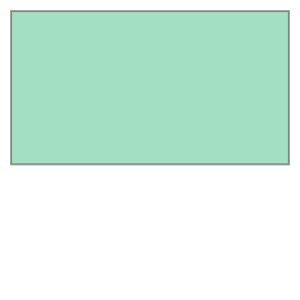

In [5]:
fields_gdf["bboxes"].iloc[0]

In [7]:
# Convert geometries to a list
geometries = list(fields_gdf.bboxes)

# Define batch size (adjust based on available memory)
batch_size = 10_000  

# Process geometries in chunks
chunks = [geometries[i:i + batch_size] for i in range(0, len(geometries), batch_size)]

# Initialize empty MultiPolygon
merged = None

for chunk in tqdm(chunks, desc="Merging geometries", unit="batch"):
    if merged is None:
        merged = union_all(chunk)  # First batch
    else:
        merged = union_all([merged] + chunk).convex_hull  # Merge with existing result

Merging geometries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [02:06<00:00,  1.32batch/s]


In [8]:
gdf = gpd.GeoDataFrame(geometry=[merged], crs=fields_gdf.crs)
gdf.to_file("uk_fields_union.geojson", driver="GeoJSON")

In [16]:
fields_gdf["determination_datetime"].unique()

<DatetimeArray>
['2021-06-01 00:00:00+00:00']
Length: 1, dtype: datetime64[ms, UTC]

# France

In [7]:
france_fields_gdf = gpd.read_parquet("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/france_eurocrops_2018_fiboa.parquet")
france_fields_gdf.head()

,geometry,id,area,code_culture,code_group,determination_datetime,EC_trans_n,EC_hcat_n,EC_hcat_c
0,"POLYGON ((849735.439 6550875.519, 849737.06 65...",38812,2.68,ORH,3,2018-01-15 00:00:00+00:00,Winter barley,winter_barley,3301010401
1,"POLYGON ((849968.343 6550277.717, 850033.702 6...",38905,20.49,BTH,1,2018-01-15 00:00:00+00:00,Soft winter wheat,winter_common_soft_wheat,3301010101
2,"POLYGON ((836239.463 6541366.745, 836239.01 65...",38801,1.49,ORH,3,2018-01-15 00:00:00+00:00,Winter barley,winter_barley,3301010401
3,"POLYGON ((836672.766 6542164.668, 836609.069 6...",38816,0.27,SOG,4,2018-01-15 00:00:00+00:00,Sorghum,millet_sorghum,3301010900
4,"POLYGON ((837134.128 6542614.464, 837103.154 6...",38907,0.19,J6S,11,2018-01-15 00:00:00+00:00,Fallow land 6 years or more declared as Ecolog...,fallow_land_not_crop,3301110000


In [4]:
france_fields_gdf["determination_datetime"].nunique()

1

In [18]:
print(f"France fields count: {france_fields_gdf.shape[0]}")
print(f"France fields CRS: {france_fields_gdf.crs}")

France fields count: 9517878
France fields CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "RGF93 Lambert 93", "base_crs": {"name": "RGF93 geographiques (dms)", "datum": {"type": "GeodeticReferenceFrame", "name": "Reseau Geodesique Francais 1993 v1", "ellipsoid": {"name": "GRS 1980", "semi_major_axis": 6378137, "inverse_flattening": 298.257222101}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}, {"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}]}, "id": {"authority": "IGNF", "code": "RGF93G"}}, "conversion": {"name": "unnamed", "method": {"name": "Lambert Conic Conformal (2SP)", "id": {"authority": "EPSG", "code": 9802}}, "parameters": [{"name": "Latitude of false origin", "value": 46.5, "unit": "degree", "id": {"authority": "EPSG", "code": 8821}}, {"name": "Longitude of false origin", "

In [19]:
# Step 1: Load the Sentinel-2 MGRS grid (replace with your downloaded file)
mgrs_grid_path = "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/grid.geojson"  # Downloaded MGRS grid file
mgrs_gdf = gpd.read_file(mgrs_grid_path)

# Ensure the grid is in a projected CRS (e.g., EPSG:27700 for your fields)
mgrs_gdf = mgrs_gdf.to_crs(france_fields_gdf.crs)

In [ ]:
france_intersecting_tiles = efficient_intersection_with_validation(mgrs_gdf, france_fields_gdf)

Processing geometries: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 56686/56686 [02:15<00:00, 419.68it/s]


In [24]:
france_intersecting_tiles = filter_sentinel_tiles(france_intersecting_tiles)

In [25]:
print(f"#Tiles for France: {france_intersecting_tiles.shape[0]}")

#Tiles for France: 98


In [4]:
france_intersecting_tiles = gpd.read_file(
    "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/france_intersecting_tiles.geojson"
)

In [7]:
france_intersecting_tiles["geometry"] = france_intersecting_tiles["geometry"].apply(extract_polygons)

In [8]:
# Apply this function before exporting to GeoJSON
france_intersecting_tiles.to_file(
    "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/france_intersecting_tiles.geojson",
    driver="GeoJSON"
)

# Extract a subset of tiles

In [2]:
uk_fields_tiles = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/intersections_gdf_correct_tiles.geojson")
uk_fields_convex_hull = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/uk_fields_union.geojson")
print(f"#UK fields tiles: {uk_fields_tiles.shape[0]}")

#UK fields tiles: 72


In [3]:
france_fields_tiles = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/france_intersecting_tiles.geojson")
france_fields_convex_hull = union_all([geom for geom in france_fields_tiles["geometry"]]).convex_hull
france_fields_convex_hull = gpd.GeoDataFrame(geometry=[france_fields_convex_hull], crs=france_fields_tiles.crs)
# france_fields_convex_hull.to_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/ssl_geometries/france_fields_union.geojson", driver="GeoJSON")
print(f"#France fields tiles: {france_fields_tiles.shape[0]}")

#France fields tiles: 98


In [4]:
france_fields_tiles.crs

<Projected CRS: EPSG:2154>
Name: RGF93 v1 / Lambert-93
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: France - onshore and offshore, mainland and Corsica (France métropolitaine including Corsica).
- bounds: (-9.86, 41.15, 10.38, 51.56)
Coordinate Operation:
- name: Lambert-93
- method: Lambert Conic Conformal (2SP)
Datum: Reseau Geodesique Francais 1993 v1
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [4]:
def generate_disjoint_squares(convex_shape, epsg, k, n, save_path=None):
    """
    Generates k disjoint nxn km squares inside a convex shapely polygon.
    
    :param convex_shape: shapely.geometry.Polygon (convex) defining the boundary.
    :param epsg: int, EPSG code for the coordinate reference system.
    :param k: int, number of squares to generate.
    :param n: int, square size in km (nxn km squares).
    :param save_path: str or None, path to save output GeoJSON if provided.
    :return: geopandas.GeoDataFrame containing the squares.
    """
    # Convert km to CRS units (assumed to be meters for projected CRS)
    square_size_m = n * 1000  # Convert km to meters
    
    # Get bounds of the convex shape
    minx, miny, maxx, maxy = convex_shape.bounds
    
    squares = []
    attempts = 0
    max_attempts = k * 10  # Avoid infinite loops in case of failure
    
    while len(squares) < k and attempts < max_attempts:
        attempts += 1
        
        # Randomly pick a bottom-left coordinate inside the bounding box
        x = random.uniform(minx, maxx - square_size_m)
        y = random.uniform(miny, maxy - square_size_m)
        
        candidate_square = box(x, y, x + square_size_m, y + square_size_m)
        
        # Check if it fits inside the convex shape and does not overlap existing squares
        if convex_shape.contains(candidate_square) and all(not s.intersects(candidate_square) for s in squares):
            squares.append(candidate_square)
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=squares, crs=f"EPSG:{epsg}")
    
    # Save to file if required
    if save_path:
        gdf.to_file(save_path, driver='GeoJSON')
    
    return gdf


In [11]:
field_areas = generate_disjoint_squares(uk_fields_convex_hull.geometry[0], 27700, 2500, 5, "field_areas.geojson")

In [5]:
field_areas = generate_disjoint_squares(france_fields_convex_hull.geometry[0], 2154, 5000, 5, "france_field_areas.geojson")

In [12]:
intersecting_fields = efficient_intersection_with_validation(fields_gdf, field_areas)
print(f"#Intersecting fields: {intersecting_fields.shape[0]}")

Processing geometries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1665637/1665637 [03:45<00:00, 7381.73it/s]


#Intersecting fields: 208835


In [8]:
intersecting_fields = efficient_intersection_with_validation(france_fields_gdf.to_crs("epsg:2154"), field_areas)
intersecting_fields.to_file("france_fields_chosen_subset_5km.geojson", driver="GeoJSON")
print(f"#Intersecting fields: {intersecting_fields.shape[0]}")

Processing geometries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 9517878/9517878 [21:56<00:00, 7228.56it/s]


#Intersecting fields: 1091614


In [22]:
intersecting_fields.to_file("uk_fields_chosen_subset.geojson", driver="GeoJSON")

In [23]:
intersecting_fields.to_file("france_fields_chosen_subset.geojson", driver="GeoJSON")

In [6]:
intersecting_fields = gpd.read_file("france_fields_chosen_subset.geojson")
intersecting_fields.head(2)

,id,area,code_culture,code_group,determination_datetime,EC_trans_n,EC_hcat_n,EC_hcat_c,geometry
0,9400554,26.620001,PPH,18,2018-01-15 00:00:00+00:00,Permanent pasture - predominantly grass (woody...,pasture_meadow_grassland_grass,3302000000,"POLYGON ((901476.774 6578036.929, 901533.818 6..."
1,9400555,0.680000,PPH,18,2018-01-15 00:00:00+00:00,Permanent pasture - predominantly grass (woody...,pasture_meadow_grassland_grass,3302000000,"POLYGON ((900731.241 6577936.45, 900730.491 65..."


In [ ]:
field_areas = gpd.read_file("france_field_areas.geojson")

In [9]:
field_areas_refined = efficient_intersection_with_validation(field_areas, intersecting_fields)
field_areas_refined.to_file("france_fields_tiles_chosen_subset_5km.geojson")
print(f"#Resulting areas / tiles: {field_areas_refined.shape[0]}")

Processing geometries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3400.55it/s]


#Resulting areas / tiles: 2373


In [8]:
print(f"France 10km x 10km tiles: {field_areas_refined.shape[0]}")

France 10km x 10km tiles: 240


In [25]:
field_areas_refined.shape[0]

105

In [ ]:
uk_kept_tiles = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/uk_fields_tiles_chosen_subset_5km.geojson")
intersecting_fields = efficient_intersection_with_validation(fields_gdf, uk_kept_tiles)
intersecting_fields.to_file("uk_fields_chosen_subset.geojson", driver="GeoJSON")
print(f"#Intersecting fields: {intersecting_fields.shape[0]}")

Processing geometries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1665637/1665637 [03:44<00:00, 7431.36it/s]


#Intersecting fields: 208835


In [5]:
uk_kept_tiles = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/uk_fields_tiles_chosen_subset_5km.geojson")
intersecting_fields = gpd.read_file("/Users/Shared/Quantum/Projects/plot_boundary_detection/code/load_tiles/uk_fields_chosen_subset.geojson")
asserted_tiles = efficient_intersection_with_validation(uk_kept_tiles, intersecting_fields)

print(f"#Original tiles: {uk_kept_tiles.shape[0]}")
print(f"#Asserted tiles: {asserted_tiles.shape[0]}")

Processing geometries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [00:00<00:00, 4231.41it/s]

#Original tiles: 1191
#Asserted tiles: 1191
